In [14]:
import os
sys.path.append("C:\\Users\\Andrew\\OneDrive - University College London\\_PhD\\Papers - Drafts\\J5_JASA_Lockdown-SS")

from scripts import lockdown_mlm as mlm
import pandas as pd
from pathlib import Path
import numpy as np
import time
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scripts import lockdown_mlm_rirs as rirs

import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="ticks")
sns.set_context("paper", font_scale=1.4)

# Define some constants and options
## variables
dep_vars = ["Natural", "Traffic", "Human", "Other", "loudness", "overall", "Pleasant", "Eventful"]

FEATS_LISTS = mlm.FEATS_LISTS
remove = ["FS_TEMP", "LAeq_TEMP", "LCeq_TEMP", "LZeq_TEMP", "I_TEMP", "N_TEMP", "R_TEMP", "S_TEMP", "SIL_TEMP", "THD_TEMP", "T_TEMP"]

for k in remove:
    FEATS_LISTS.pop(k, None)

acoustic_vars = sorted({x for v in FEATS_LISTS.values() for x in v})

## processing options
nonlinear_transformations = [] # Leave a blank list to do no transformations
criterion = "aic"

# ===============================================================
DATA_DIR = Path("C:\\Users\\Andrew\\OneDrive - University College London\\_PhD\\Papers - Drafts\\J5_JASA_Lockdown-SS\\data")
ssidData = pd.read_csv(DATA_DIR.joinpath("2020-08-13\\LondonVeniceBINResults_2020-08-13_4.csv"))

for col_name in ["Lockdown"]:
    ssidData[col_name] = ssidData[col_name].astype('category')

# Cutdown the dataset
cols = ["GroupID", "LocationID", "SessionID", "Lockdown"] + dep_vars + acoustic_vars
ssidData = ssidData[cols]

# Compress to mean of each GroupID
# compressData = ssidData.copy()
compressData = ssidData.groupby(["GroupID"]).mean()
compressData = compressData.merge(ssidData[["GroupID", "LocationID", "SessionID", "Lockdown"]].drop_duplicates(),  on="GroupID")

location_codes = pd.Categorical(compressData["LocationID"]).codes
compressData["LocationID_codes"] = location_codes
compressData.loc[compressData["Lockdown"] == 1].dropna(inplace=True)
compressData = compressData.dropna(subset=acoustic_vars)

compressData, acoustic_vars = mlm.nonlinear_features(compressData, acoustic_vars, transformations=nonlinear_transformations)
print(f"Initial features number: {len(acoustic_vars)}")

# Standardise
from sklearn.preprocessing import StandardScaler
compressData = compressData.replace([np.inf, -np.inf], np.nan)
compressData = compressData.dropna(subset=acoustic_vars)
scaler = StandardScaler()
# compressData[acoustic_vars] = scaler.fit_transform(compressData[acoustic_vars])

# #############################################################

prelockdownData = compressData.loc[compressData["Lockdown"] == 1]
prelockdownData = prelockdownData.dropna()
print(prelockdownData.shape)

lockdownData = compressData.loc[compressData["Lockdown"] == 2]
print(lockdownData.shape)


Initial features number: 119
(661, 132)
(573, 132)


In [88]:
X = np.array(prelockdownData[acoustic_vars + ["LocationID_codes"]])
y = np.array(prelockdownData["Pleasant"])
y = y.reshape(-1,1)

sc_X = StandardScaler()
sc_y = StandardScaler()
X = sc_X.fit_transform(X)
y = sc_y.fit_transform(y)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

# Training the SVR model on the training set
from sklearn.svm import SVR
regressor = SVR(kernel='rbf')
regressor.fit(X_train, y_train)

# Predicting the Test set Results
y_pred = regressor.predict(X_test)
y_pred = sc_y.inverse_transform(y_pred)

# Comparing the test set with predicted values
df = pd.DataFrame({
    'Real Values': sc_y.inverse_transform(y_test.reshape(-1)),
    'Predicted Values': y_pred
    })
df.head

<bound method NDFrame.head of      Real Values  Predicted Values
0      -0.323223          0.015502
1       0.280330          0.230522
2       1.000000          0.544543
3       0.219670          0.415441
4      -0.103553          0.298156
..           ...               ...
128     0.353553          0.525682
129     0.332107          0.582827
130    -0.648181          0.151751
131     0.396447         -0.327368
132     0.258883         -0.192825

[133 rows x 2 columns]>

0.22021693142589027

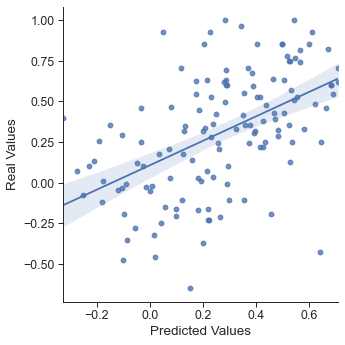

In [89]:
sns.lmplot('Predicted Values','Real Values', data=df)
regressor.score(X_test, y_test)

In [73]:
regressor.coef_

AttributeError: coef_ is only available when using a linear kernel

In [49]:
# Visualising
X_grid = np.arange(min(X), max(X), 0.1)
X_grid = X_grid.reshape((len(X_grid), 1))
plt.scatter(sc_X.inverse_transform(X_test), 
sc_y.inverse_transform(y_test.reshape(-1)), color='red')
plt.scatter(sc_X.inverse_transform(X_test), y_pred, color='green')

plt.title('SVR Regression')
plt.xlabel('SIL_50')
plt.ylabel('Pleasantness')
plt.show()

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

Automatically created module for IPython interactive environment


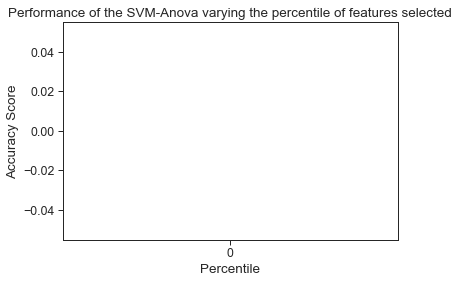

In [41]:
print(__doc__)

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectPercentile, chi2
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR

X = np.array(prelockdownData[acoustic_vars])
y = np.array(prelockdownData['Pleasant'])

# #############################################################################
# Import some data to play with
# X, y = load_iris(return_X_y=True)
# Add non-informative features
# np.random.seed(0)
# X = np.hstack((X, 2 * np.random.random((X.shape[0], 36))))

# #############################################################################
# Create a feature-selection transform, a scaler and an instance of SVM that we
# combine together to have an full-blown estimator
clf = Pipeline([('anova', SelectPercentile(chi2)),
                ('scaler', StandardScaler()),
                ('svr', SVR(kernel="rbf"))])

# #############################################################################
# Plot the cross-validation score as a function of percentile of features
score_means = list()
score_stds = list()
percentiles = (1, 3, 6, 10, 15, 20, 30, 40, 60, 80, 100)

for percentile in percentiles:
    clf.set_params(anova__percentile=percentile)
    this_scores = cross_val_score(clf, X, y)
    score_means.append(this_scores.mean())
    score_stds.append(this_scores.std())

plt.errorbar(percentiles, score_means, np.array(score_stds))
plt.title(
    'Performance of the SVM-Anova varying the percentile of features selected')
plt.xticks(np.linspace(0, 100, 11, endpoint=True))
plt.xlabel('Percentile')
plt.ylabel('Accuracy Score')
plt.axis('tight')
plt.show()

In [43]:
percentile = percentiles[4]
clf.set_params(anova__percentile = percentile)
# this_scores = cross_val_score(clf, X, y)
this_scores

Pipeline(memory=None,
         steps=[('anova',
                 SelectPercentile(percentile=15,
                                  score_func=<function chi2 at 0x00000200EC0A0048>)),
                ('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svr',
                 SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
                     gamma='scale', kernel='rbf', max_iter=-1, shrinking=True,
                     tol=0.001, verbose=False))],
         verbose=True)